# Ariane 5 Vulcain Engine

This notebook attempts to use Bamboo to recreate experimental and simulation data produced for the Ariane 5's Vulcain engine by Messerschmitt-Bölkow-Blohm (MBB).

Key points on the Vulcain engine:
- The combustion chamber is cooled seperately to the nozzle extension
- The nozzle extension is cooled by dump cooling
- The combustion chamber is regeneratively cooled
- The LH2 coolant is above the critical pressure, and so does not form bubbles or 'boil off' in the traditional sense.

We will only attempt to model the regeneratively cooled combustion chamber.

### Conclusions:
- Bamboo shows good overall agreement with the Deutsche Aerospace simulation data (overpredicted the peak heat transfer rate by 10.38%)
- Bamboo very accurately predicts the exit coolant temperature (within 3% of the experimental value).
- Bamboo has a sharper peak in heat transfer rate than the Deutsche Aerospace data. This may be due due to Bamboo neglecting any axial heat transfer (which would smooth out the peak).
- It's important to use the throat conditions in pypropep to get the perfect gas gamma, otherwise the perfect gas model deviates significantly from equilibrium (e.g. CEA or ProPEP) and real life values.

### References:

- [1] - Kirner et al 1993, Development Status of the Vulcain Thrust Chamber (http://ftp.demec.ufpr.br/CFD/bibliografia/propulsao/kirner_et_al_1993.pdf)
- [2] - Kuhl et al 2002, Thermomechanical Analysis and Optimization of Cryogenic Liquid Rocket Engines (https://www.researchgate.net/publication/224789875_Thermomechanical_Analysis_and_Optimization_of_Cryogenic_Liquid_Rocket_Engines)
- [3] - Haidn, Advanced Rocket Engines (https://www.macro-inc.com/NASADocs/AdvanceRocketEnginesEN-AVT-150-06.pdf)
- [4] - Mårtensson et al, Rocket Engines: Turbomachinery (https://www.sto.nato.int/publications/STO%20Educational%20Notes/RTO-EN-AVT-150/EN-AVT-150-05.pdf) (note this link downloads a PDF)


### Uses of references:
- [1] - Predicted and experimental coolant temperatures and heat transfer rates for the Vulcain engine, from page 10.
- [2] - Thermal conductivity of the walls (310 W/m/K), from page 844.
- [3] - Cooling channel dimensions were estimated using the image on page 21.
- [4] - Turbopump exit pressure, assumed to be the coolant inlet pressure, from the graph on page 3 (noting that Vulcain is a gas-generator cycle with 1450 psi chamber pressure, giving ~2400 psi pump exit pressure (165 bar))



In [1]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

Using a an online graph image-to-data converter (http://www.graphreader.com/), we can obtain the raw data from Deutsche Aerospace.

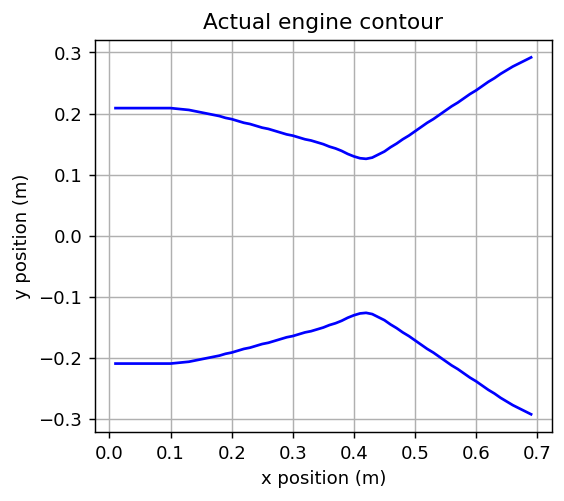

In [2]:
#'x' key corresponds to position in metres (0 = beginning of chamber). 'y' corresponds to the data.

#Coolant temperature in K 
coolant_temperature_data = {"x":[0.00128, 0.04343, 0.10803, 0.21204, 0.27883, 0.36095, 0.44745, 0.51533, 0.59416, 0.63686, 0.68558],
                            "y":[96.883,93.279,87.802,78.865,73.099,64.162,55.802,48.883,42.396,38.793,35.045]}

#Heat transfer rate in W/cm^2
heat_transfer_rate = {"x":[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68],
                      "y":[3392.201,3475.771,3546.043,3615.201,3687.672,3750.87,3777.94,3770.553,3753.173,3733.547,3713.45,3694.597,3678.699,3667.447,3661.987,3662.784,3670.26,3684.835,3705.399,3726.831,3746.404,3771.594,3809.186,3857.225,3912.077,3970.107,4029.233,4095.268,4176.523,4281.072,4408.404,4547.257,4690.436,4840.756,5000.567,5167.592,5340.659,5527.388,5731.296,5874.496,5929.249,5952.304,5898.527,5798.601,5657.307,5152.925,4818.711,4490.73,4162.569,3860.988,3574.203,3266.901,2978.681,2748.285,2554.031,2382.503,2230.471,2095.176,1974.176,1865.628,1768.807,1683.075,1607.502,1541.046,1482.716,1431.949,1388.386,1351.674,1321.606]}

#Engine contour (m) - up to the beginning of the nozzle extension.
engine_contour = {"x":[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69],
                  "y":[0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.208,0.207,0.206,0.204,0.202,0.2,0.198,0.196,0.193,0.191,0.188,0.185,0.183,0.18,0.177,0.175,0.172,0.169,0.166,0.164,0.161,0.158,0.156,0.153,0.15,0.146,0.143,0.139,0.134,0.13,0.127,0.126,0.128,0.133,0.138,0.145,0.151,0.158,0.164,0.171,0.178,0.185,0.191,0.198,0.205,0.212,0.218,0.225,0.232,0.238,0.245,0.252,0.258,0.265,0.271,0.277,0.282,0.287,0.292]}

experimental_T_in = 36.198
experimental_T_out = 98.613
experimental_qdot = {"x" : 0.48741, "y" : 4475.676}

#Plot the engine contour
fig, axs = plt.subplots()
axs.plot(engine_contour["x"], engine_contour["y"], color = 'blue')
axs.plot(engine_contour["x"], -np.array(engine_contour["y"]), color = 'blue')
axs.set_aspect('equal')
axs.grid()
plt.title("Actual engine contour")
axs.set_xlabel("x position (m)")
axs.set_ylabel("y position (m)")
plt.show()

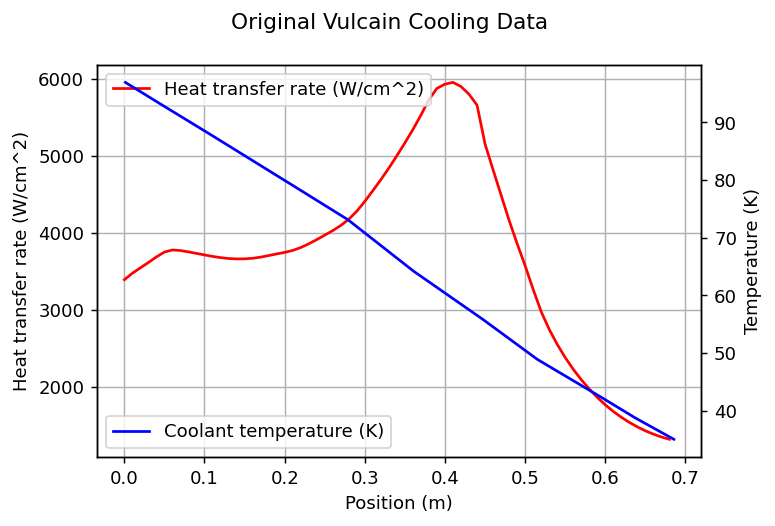

In [3]:
#Plot the original data from Deutsche Aerospace
fig, ax1 = plt.subplots()
fig.suptitle("Original Vulcain Cooling Data")

#Plot heat transfer rates
ax1.plot(heat_transfer_rate["x"], heat_transfer_rate["y"], label="Heat transfer rate (W/cm^2)", color="red")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()
ax1.legend(loc = "upper left")

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       #Second axes that shares the same x-axis as ax1
ax2.plot(coolant_temperature_data["x"], coolant_temperature_data["y"], label="Coolant temperature (K)", color="blue")
ax2.set_ylabel("Temperature (K)")
ax2.legend(loc = 'lower left')

plt.show()

### Bamboo engine model

The Vulcain uses a liquid oxygen and liquid hydrogen fed system.

In [4]:
thrust = 1007.7e3   #N - in vacuum
isp = 439           #seconds - in vacuum
pc = 100e5          #chamber pressure
OF_ratio = 5.6      #by mass I believe

# Actual mass flow rate was incompatible with throat area (for perfect gas choking)
# Bamboo suggested using this value (which is slightly lower than the actual value of 234 kg/s - maybe because the 234 includes 
# dump cooling).
mdot = 216.467306 

#Use pypropep to get chamber temperature
ppp.init()
p_froz = ppp.FrozenPerformance()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

#Add propellants by mass fractions
p_froz.add_propellants_by_mass([(lox, OF_ratio), (lh2, 1)])

#Adiabatic combustion using chamber pressure                      
p_froz.set_state(P = pc/1e5, Pe = 1)   

#Get results - use throat conditions for gamma and cp! Otherwise the perfect gas model deviates a lot from equilibrium calculations.
gamma = p_froz.properties[1].Isex   #pyrpopep uses 'Isex' for the ratio of specific heats. Index [1] means throat conditions
cp = 1000*p_froz.properties[1].Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T         #Index [0] means chamber conditions


print(f"\nTotal mass flow rate = {mdot} kg/s")
print(f"Chamber temperature = {Tc} K")

print("\nCombustion product composition:")
print(p_froz.composition["throat"])

Loaded 1921 thermo species
Loaded 1031 propellants

Total mass flow rate = 216.467306 kg/s
Chamber temperature = 3459.2606127242298 K

Combustion product composition:
[('H2O', 0.6493671319106238), ('H2', 0.2896925690851782), ('OH', 0.028980423622929952), ('H', 0.028801796474919292), ('O', 0.0016810512414820072), ('O2', 0.0014520541971763574), ('HO2', 1.7031381331243065e-05), ('H2O2', 7.94208687267654e-06), ('O3', 0.0)]


In [5]:
#Need to convert contour data into something we can use for Bamboo - shift the data so the throat occurs at x = 0.
throat_index = np.argmin(engine_contour["y"])
throat_pos = engine_contour["x"][throat_index]
nozzle_x = (np.array(engine_contour["x"]) - throat_pos)[throat_index:]
nozzle_y = np.array(engine_contour["y"])[throat_index:]

chamber_x = (np.array(engine_contour["x"]) - throat_pos)[:throat_index+1]
chamber_y = np.array(engine_contour["y"])[:throat_index+1]

#Set up the engine object
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)   
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle(type = "custom", xs = nozzle_x, ys = nozzle_y)

engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

In [6]:
#Engine geometry
engine.add_geometry(inner_wall_thickness = 1.7e-3,
                    style = "custom",
                    xs = chamber_x,
                    ys = chamber_y)


In [7]:
'''Transport properties'''
#Setup the exhaust gas transport properties - assume the exhaust gas is purely water for simplicity
def Pr_gas(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "WATER")

def mu_gas(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "WATER")

def k_gas(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "WATER")

gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_gas,
                                                mu = mu_gas,
                                                k = k_gas)

#Set up the coolant transport properties
#Round temperatures up to 12 K - CoolProp seems unhappy below this for LH2
def Pr_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

def rho_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

'''
def T_from_enthalpy(enthalpy, p):
    return PropsSI('T','H', enthalpy,'P', p, 'HYDROGEN')

def enthalpy_from_T(T, p):
    return PropsSI('H','T', T, 'P', p, 'HYDROGEN')
'''

#H2 doesn't seem to exactly 'boil-off' in the state it's in, so just use cp for coolant temperature rise, not enthalpies.
coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant)

#Add the gas transport properties to the engine
engine.add_exhaust_transport(gas_transport)

#Coolant transport properties will get used later when creating adding the CoolingJacket to the engine

In [8]:
#Wall material
vulcain_wall_material = bam.cooling.Material(E = float("NaN"), 
                                    sigma_y = float("NaN"), 
                                    poisson = float("NaN"), 
                                    alpha = float("NaN"), 
                                    k = 310, 
                                    c = float("NaN"))

In [9]:
#Dimensions estimated from the image in Reference [3]
engine.add_cooling_jacket(inner_wall_material = vulcain_wall_material, 
                          inlet_T = coolant_temperature_data["y"][-1],                           
                          inlet_p0 = 165e5, 
                          coolant_transport = coolant_transport, 
                          mdot_coolant = mdot/(OF_ratio + 1), 
                          configuration = "vertical", 
                          channel_height = 9.1e-3,
                          blockage_ratio = 0.5,
                          number_of_ribs = 288)

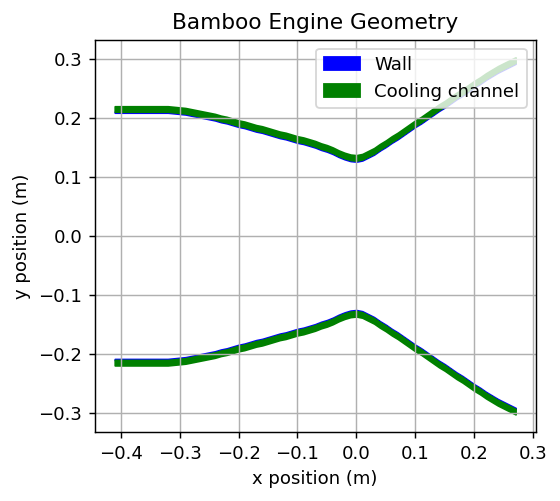

In [10]:
engine.plot_geometry()
plt.title("Bamboo Engine Geometry")
plt.show()

In [11]:
#Run simulation without fudge factor
bamboo_data = engine.steady_heating_analysis(to_json = False, 
                                             h_gas_model = 'bartz-sigma', 
                                             h_coolant_model = 'gnielinski')

NOTE: No enthalpy data provided for the coolant - will use specific heat capacity to predict temperature rises.


In [12]:
#Convert heat transfer rates to per unit area - divide by the circumference
q_per_area = np.zeros(len(bamboo_data['q_dot']))
for i in range(len(q_per_area)):
    q_per_area[i] = bamboo_data['q_dot'][i]/(2*np.pi*engine.y(bamboo_data["x"][i]))


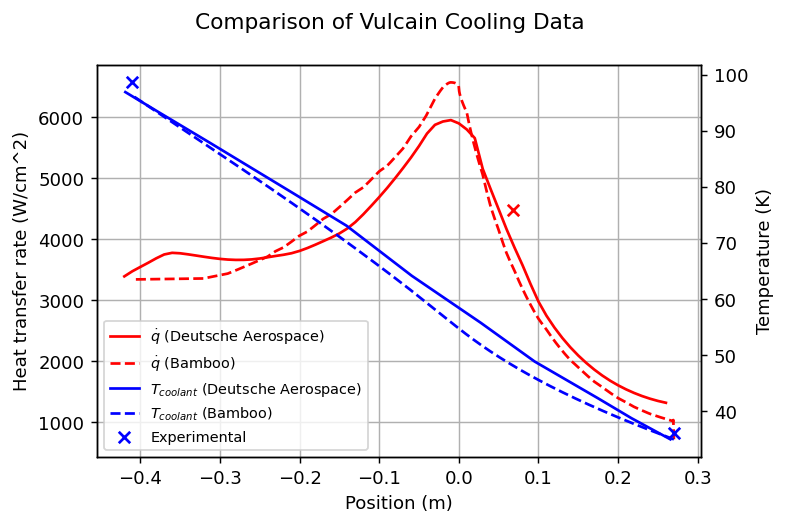

Experimental coolant exit temperature (Deutsche Aerospace) = 98.61 K
Predicted coolant exit temperature (Bamboo) = 96.29 K
Percentage error in coolant exit temperature = 2.36%

Peak heat transfer rate (Deutsche Aerospace) = 5952 W/cm2
Peak heat transfer rate (Bamboo) = 6570 W/cm2
Percentage error in peak heat transfer rate = 10.38%


In [13]:
#Compare results with data from paper
fig, ax1 = plt.subplots()
fig.suptitle("Comparison of Vulcain Cooling Data")

#Plot heat transfer rates
ax1.plot(np.array(heat_transfer_rate["x"]) - throat_pos, 
         heat_transfer_rate["y"], 
         label= r"$\dot{q}$ (Deutsche Aerospace)", 
         color= "red")

ax1.plot(bamboo_data["x"], 
         q_per_area*(1e-2)**2, 
         label= r"$\dot{q}$ (Bamboo)", 
         color="red", 
         linestyle = "--")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       
ax2.plot(np.array(coolant_temperature_data["x"]) - throat_pos, 
         coolant_temperature_data["y"], 
         label = r"$T_{coolant}$ (Deutsche Aerospace)", 
         color= "blue")

ax2.plot(bamboo_data["x"], bamboo_data["T_coolant"], 
         label= r"$T_{coolant}$ (Bamboo)", 
         color= "blue", 
         linestyle = "--")

ax2.set_ylabel("Temperature (K)")

# Plot their experimental datapoints
ax1.scatter(experimental_qdot["x"] - throat_pos, experimental_qdot["y"], marker = 'x', s = 40, color = "red")
ax2.scatter(bamboo_data["x"][0], experimental_T_in, s = 40, marker = 'x', color = "blue")
ax2.scatter(bamboo_data["x"][-1], experimental_T_out, s = 40, marker = 'x', color = "blue", label = "Experimental")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc = 'lower left', prop={'size': 8})

plt.show()

print(f'Experimental coolant exit temperature (Deutsche Aerospace) = {experimental_T_out:.2f} K')
print(f'Predicted coolant exit temperature (Bamboo) = {bamboo_data["T_coolant"][-1]:.2f} K')
percent_error = 100*(bamboo_data["T_coolant"][-1] - experimental_T_out)/experimental_T_out
print(f'Percentage error in coolant exit temperature = {abs(percent_error):.2f}%\n')

print(f'Peak heat transfer rate (Deutsche Aerospace) = {max(heat_transfer_rate["y"]):.0f} W/cm2')
print(f'Peak heat transfer rate (Bamboo) = {max(q_per_area*(1e-2)**2):.0f} W/cm2')
percent_error = 100*(max(q_per_area*(1e-2)**2) - max(heat_transfer_rate["y"]))/max(heat_transfer_rate["y"])
print(f'Percentage error in peak heat transfer rate = {abs(percent_error):.2f}%')
